## 3HB Yield Calculations

Calculate yield of 3HB possible from
* C. ljungdahlii alone on syngas
* E. coli alone from acetate

These results can be fed to Anthony's model to examine productivity of the co-culture vs. monoculture for this product

Critically, the approaches below account for how 3HB production at different yields affects growth yield, e.g. the tradeoff between growth and production.

In [71]:
import numpy as np
import copy
import cobra
from cobra import Metabolite, Model, Reaction
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

### E. coli 3HB from Acetate
Use the E. coli core model and FBA to examine tradeoff between 3HB production and growth. First add the 3HB reactions and any missing metabolites to the model.

In [13]:
model = cobra.io.read_sbml_model('e_coli_core.xml')

In [14]:
#Add reactions and metabolites for 3HB manually

#New metabolites
acaccoa_c = Metabolite('acaccoa_c', name = 'acetoacetyl-CoA', compartment = 'c')
hbcoa_c = Metabolite('3hbcoa_c', name = '3-hydroxybutyryl-CoA', compartment = 'c')
hb_c = Metabolite('3hb_c', name = 'S-3-hydroxybutyrate', compartment = 'c')
hb_e = Metabolite('3hb_e', name = 'S-3-hydroxybutyrate', compartment = 'e')

#Exisiting metabolites
accoa_c = model.metabolites.get_by_id('accoa_c')
coa_c = model.metabolites.get_by_id('coa_c')
nadh_c = model.metabolites.get_by_id('nadh_c')
nad_c = model.metabolites.get_by_id('nad_c')
h_c = model.metabolites.get_by_id('h_c')
h_e = model.metabolites.get_by_id('h_e')
h2o_c = model.metabolites.get_by_id('h2o_c')
ac_c = model.metabolites.get_by_id('ac_c')

#Reactions
THL = Reaction('THL', name = 'Thiolase', lower_bound = -1000, upper_bound = 1000)
THL.add_metabolites({accoa_c: -2, acaccoa_c: 1., coa_c: 1})

HBDH = Reaction('HBDH', name = '3-hydroxubutyryl-CoA dehydrogenase', lower_bound = -1000, upper_bound = 1000)
HBDH.add_metabolites({acaccoa_c:-1, nadh_c: -1, hbcoa_c: 1, nad_c: 1, h_c: -1})

PCT = Reaction('PCT', name = 'Propionyl-CoA trarnsferase', lower_bound = -1000, upper_bound = 1000)
PCT.add_metabolites({hbcoa_c:-1, ac_c: -1, hb_c: 1, accoa_c: 1})

HBtr = Reaction('HBtr', name = '3HB transport via proton symport', lower_bound = -1000, upper_bound = 1000)
HBtr.add_metabolites({hb_c:-1, h_c:-1, h_e: 1, hb_e: 1})

EX_HB_e = Reaction('EX_HB_e', name = '3HB exchange', lower_bound = 0, upper_bound = 1000)
EX_HB_e.add_metabolites({hb_e:-1})

model.add_reactions([THL, HBDH, PCT, HBtr, EX_HB_e])

In [155]:
#Change medium to use acetate

ac_medium = copy.deepcopy(model.medium)
ac_medium['EX_glc__D_e'] = 0.0
ac_medium['EX_ac_e'] = 10.0 #mmol/gDCW/hr *****NOTE: Should be set based on known E. coli acetate uptake rates*****
model.medium = ac_medium

model.objective = 'BIOMASS_Ecoli_core_w_GAM'
solution = model.optimize()

print(f'Growth rate on acetate = {solution.objective_value:.3f} per hour, when no 3HB produced')

Growth rate on acetate = 0.173 per hour, when no 3HB produced


In [24]:
#Now change objective to 3HB and calculate yield on acetate
model.objective = model.reactions.get_by_id('EX_HB_e')
solution_3HB = model.optimize()
print(f'3HB production rate on acetate = {solution_3HB.objective_value:.3f} mmol / gdcw-hour')
ac_yield = -1*solution_3HB.objective_value/solution_3HB.fluxes['EX_ac_e']
print(f'3HB yield = {ac_yield:.2f} mol 3HB / mol acetate')
growth_rate = solution_3HB.fluxes['BIOMASS_Ecoli_core_w_GAM']
print(f'Growth rate while maximizing 3HB production is {growth_rate:.3f}')

3HB production rate on acetate = 3.173 mmol / gdcw-hour
3HB yield = 0.32 mol 3HB / mol acetate
Growth rate while maximizing 3HB production is 0.000


In [93]:
model.summary()

It will be helpful to see how 3HB yield affects growth rate. Calculate this with the "Production Envelope" function

In [26]:
from cobra.flux_analysis import production_envelope

In [85]:
#Calculate a production enevelope
prod_env = production_envelope(model, ['EX_HB_e'], objective='BIOMASS_Ecoli_core_w_GAM', carbon_sources = 'EX_ac_e')

In [86]:
#Calculate yield in the production envelope
prod_env['HB_yield'] = prod_env['EX_HB_e']/solution_3HB.fluxes['EX_ac_e']*-1.

Text(0, 0.5, '3HB Production Yield (mol/mol)')

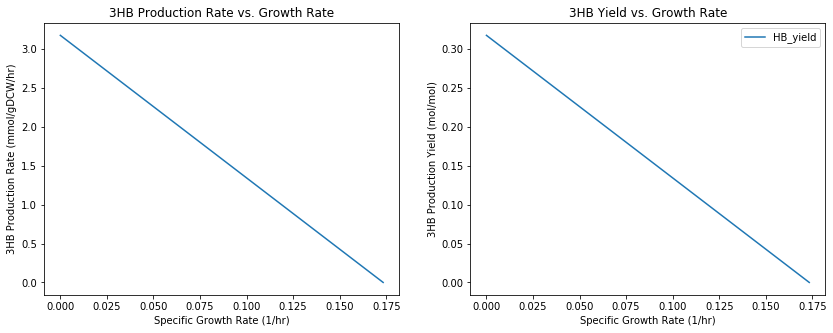

In [92]:
#Plot growth rate vs 3HB production, and growth rate vs. 3HB yield
fig, axs = plt.subplots(1,2, figsize = (14,5))
prod_env.plot(kind = 'line', y = 'EX_HB_e', x = 'flux_maximum', legend = False, ax = axs[0])
axs[0].set_title('3HB Production Rate vs. Growth Rate')
axs[0].set_ylabel('3HB Production Rate (mmol/gDCW/hr)')
axs[0].set_xlabel('Specific Growth Rate (1/hr)')
axs[1] = prod_env.plot('flux_maximum', 'HB_yield', ax = axs[1])
axs[1].set_title('3HB Yield vs. Growth Rate')
axs[1].set_xlabel('Specific Growth Rate (1/hr)')
axs[1].set_ylabel('3HB Production Yield (mol/mol)')

### 3HB Production from C. ljungdahlii

Use a very simple stoichiometric model for C. ljungdahlii to calculate approximate maximal yield, based on Alan Fast's paper (Stoichiometric and energetic analysis of non-photosynthetic CO2-fixation to support synthetic biology strategies for production of fuels and chemicals).

Model accounts for reducing equivalent (H2) and ATP cost of biomass, to allow you to look at how 3HB production changes the rate at which biomass can be produced

In [146]:
import pandas as pd

In [147]:
df = pd.read_excel('3HB_Clj.xlsx', index_col = 0 )
df

,WLP,3HB,Ac,Biomass,CO2 Accumulation,H2 Accumulation,Biomass Accumulation,Acetate Accumulation
Metabolite,,,,,,,,
CO2,-2.0,0,0,0.0,-1,0,0,0
H2,-4.0,-1,0,-0.3,0,-1,0,0
AcCoA,1.0,-1,-1,-0.5,0,0,0,0
Acetate,0.0,-1,1,0.0,0,0,0,-1
3HB,0.0,1,0,0.0,0,0,0,0
ATP,-0.5,0,1,-4.0,0,0,0,0
Biomass,0.0,0,0,1.0,0,0,-1,0
Ratio,0.0,1,0,0.0,0,0,0,-1


In [152]:
A = df.to_numpy() #Stoichiometry matrix

In [154]:
b = np.zeros(8) #Accumulation matrix
b[4] = 1 #basis is 1 mol of 3HB produced, accumulation of everything is considered an exchange reaction

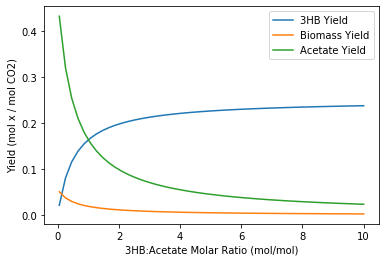

In [145]:
product_ratio = np.linspace(0.05, 10, 50) #From 0 3HB/acetate to 10 3HB/acetate
HB_yield = []
BM_yield = []
AC_yield = []
for i in product_ratio:
    A[7,7]=-1*i
    x = np.linalg.solve(A,b)
    HB_yield.append(x[1]/-x[4]) #mol 3HB / mol CO2
    BM_yield.append(x[6]/-x[4]) #mol biomass / mol CO2 (biomass MW = 26 g/mol so could easily calculate mass instead of mol)
    AC_yield.append(x[7]/-x[4]) #mol acetate / mol CO2

plt.plot(product_ratio, HB_yield, label = '3HB Yield')
plt.plot(product_ratio, BM_yield, label = 'Biomass Yield')
plt.plot(product_ratio, AC_yield, label = 'Acetate Yield')
plt.xlabel('3HB:Acetate Molar Ratio (mol/mol)')
plt.ylabel('Yield (mol x / mol CO2)')
plt.legend()

How to couple this to your existing model? 

One way would be to use the growth kinetics from the wild-type strain to calculate carbon uptake rate, rather than growth rate. Then use the yield data provided here to convert those carbon uptake rates to biomass production rates and 3HB production rates. So, your umax and Ks, etc. determine the rate of carbon uptake, and the specific yield you choose then sets both the growth rate and production rate